In [6]:
import torch
import torch.nn as nn
import librosa as rs
import numpy as np

import matplotlib.pyplot as plt   
import IPython.display as ipd


mag_estim torch.Size([257, 317])


Text(0.5, 1.0, '-20dB ~ ')

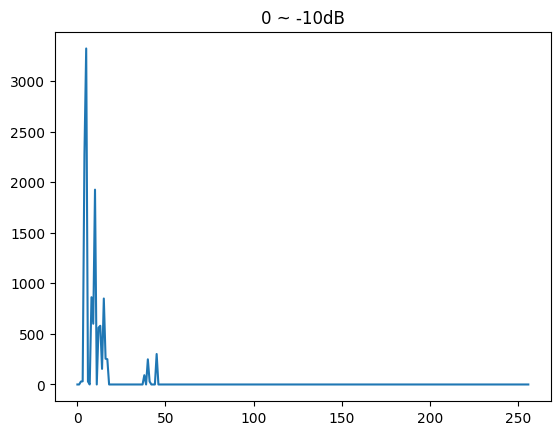

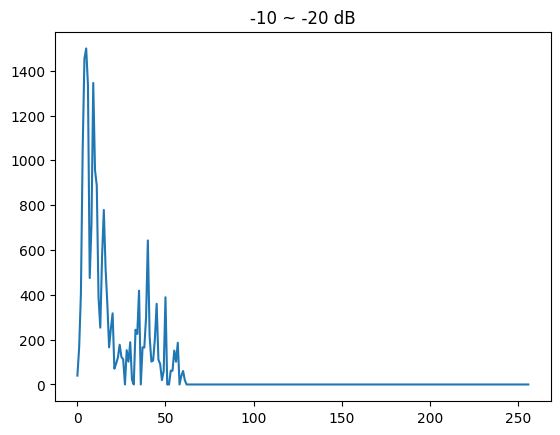

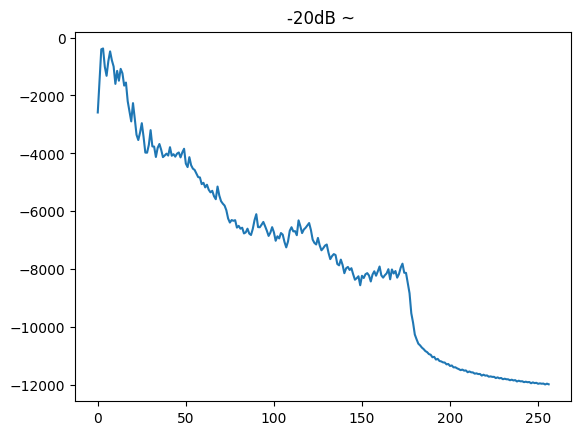

In [30]:
def fig2np(fig):
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

def mag2plot(data):
    mag = data.detach().cpu().numpy()
    mag = 10*np.log(mag)
    fig, ax = plt.subplots()
    im = plt.imshow(mag, cmap=cm.jet, aspect='auto',origin='lower')
    plt.colorbar(im)
    plt.clim(-80,20)
    
    plt.xlabel('Time')
    plt.ylabel('Freq')
    
    fig.canvas.draw()
    plot = fig2np(fig)
    return plot

def stft_to_db(stft_data):
    # STFT 도메인 데이터를 dB로 변환
    magnitude = torch.abs(stft_data)
    db_data = 20 * torch.log10(magnitude + 1e-10)  # 안정성을 위해 작은 값 추가
    return db_data

class test_module(nn.Module):
    def __init__(self) :
        super(test_module,self).__init__()

    # estim : (B,L) time domain audio
    # target :(B,L) time domain audio
    def forward(self, estim):
        spec_estim = torch.stft(estim, n_fft = 512, return_complex=True)

        mag_estim = torch.abs(spec_estim)

        print(f"mag_estim {mag_estim.shape}")

        max_estim = stft_to_db(torch.max(mag_estim))
        db_estim = stft_to_db(spec_estim)
        m10_mask = db_estim >= (max_estim - 10)
        m20_mask = (db_estim >= (max_estim - 20)) & (db_estim < (max_estim - 10))
        m30_mask = (db_estim < (max_estim - 20))

        m10_db = torch.where(m10_mask, db_estim, torch.tensor(0.0))
        m20_db = torch.where(m20_mask, db_estim, torch.tensor(0.0))
        m30_db = torch.where(m30_mask, db_estim, torch.tensor(0.0))

        m10_sum = torch.sum(m10_db,dim=1)
        m20_sum = torch.sum(m20_db,dim=1)
        m30_sum = torch.sum(m30_db,dim=1)
        
        return m10_sum, m20_sum, m30_sum
    

path = "data/female_1.wav"
raw,fs = rs.load(path)

x = torch.from_numpy(raw)
m = test_module()
y1,y2,y3 = m(x)

plt.figure()
plt.plot(y1)
plt.title("0 ~ -10dB")

plt.figure()
plt.plot(y2)
plt.title("-10 ~ -20 dB")

plt.figure()
plt.plot(y3)
plt.title("-20dB ~ ")

0.00003887 0.00027816 0.08225142
tensor(0.0826, grad_fn=<AddBackward0>)
0.00000956 0.00007217 0.04012255
tensor(0.0402, grad_fn=<AddBackward0>)


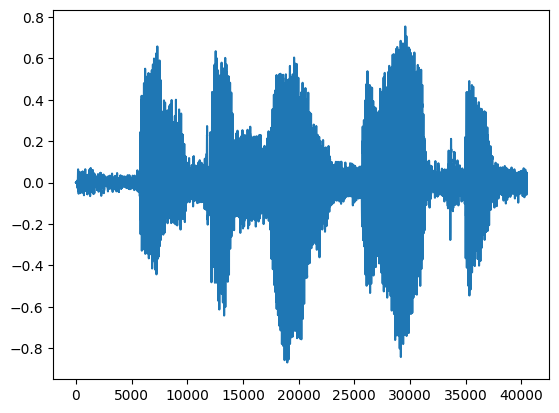

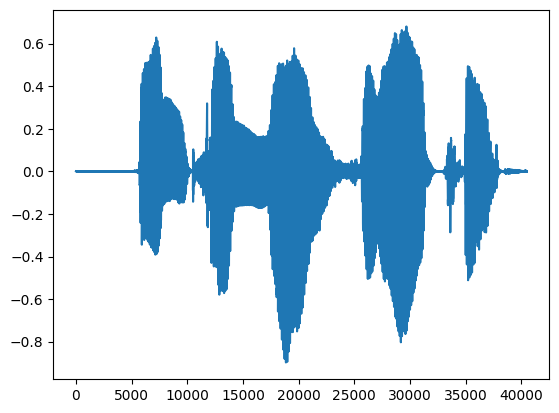

In [52]:
class MultiMagnitudeLoss(nn.Module):
    def __init__(self,
                 n_fft=512,
                 weight = [1.0,1.0,1.0],
                 PC_factor=0.3,
                 reduction = torch.mean) :
        super(MultiMagnitudeLoss,self).__init__()
        self.gamma = PC_factor
        self.reduction = reduction
        self.weight = weight
        self.n_fft = n_fft

    # estim : (B,L) time domain audio
    # target :(B,L) time domain audio
    def forward(self, estim, target):
        spec_estim = torch.stft(estim, n_fft = self.n_fft, return_complex=True)
        spec_target = torch.stft(target, n_fft = self.n_fft, return_complex=True)

        mag_estim = torch.abs(spec_estim)
        mag_target = torch.abs(spec_target)

        
        db_target = stft_to_db(spec_target)
        max_target = stft_to_db(torch.max(mag_target))
        
        m10_mask = db_target >= (max_target - 10)
        m20_mask = (db_target >= (max_target - 20)) & (db_target < (max_target - 10))
        m30_mask = (db_target < (max_target - 20))

        zero_tensor = torch.tensor(0.0, device=mag_estim.device, dtype=mag_estim.dtype, requires_grad=True)

        m10_estim = torch.where(m10_mask, mag_estim, zero_tensor)
        m20_estim = torch.where(m20_mask, mag_estim, zero_tensor)
        m30_estim = torch.where(m30_mask, mag_estim, zero_tensor)

        m10_target = torch.where(m10_mask, mag_target, zero_tensor)
        m20_target = torch.where(m20_mask, mag_target, zero_tensor)
        m30_target = torch.where(m30_mask, mag_target, zero_tensor)

        m10_dist =  m10_target**self.gamma - m10_estim**self.gamma
        m20_dist =  m20_target**self.gamma - m20_estim**self.gamma
        m30_dist =  m30_target**self.gamma - m30_estim**self.gamma

        m10_loss = self.reduction(torch.mean(m10_dist**2, dim=1))
        m20_loss = self.reduction(torch.mean(m20_dist**2, dim=1))
        m30_loss = self.reduction(torch.mean(m30_dist**2, dim=1))
                             
        print(f"{m10_loss:.8f} {m20_loss:.8f} {m30_loss:.8f}")
        
        loss = self.weight[0]*m10_loss + self.weight[1]*m20_loss + self.weight[2]*m30_loss
        return loss

path_clean = "data/female_1.wav"
path_noise = "data/cafe.wav"

clean,fs = rs.load(path_clean)
noise,fs = rs.load(path_noise)

c = torch.from_numpy(clean)
n = torch.from_numpy(noise)
n = n[:len(c)]

x = c+n
m = MultiMagnitudeLoss()
loss = m(x,c)
print(loss)

x = c+0.5*n
m = MultiMagnitudeLoss()
loss = m(x,c)
loss.backward()
print(loss)

plt.figure()
plt.plot(x)
plt.figure()
plt.plot(c)